In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import curve_fit
from IPython.display import Markdown, display


# Read in Data
Let's read in data from [ Steer C, Froelich J, Soutullo CA, Johnson M, Shaw M . (). Lisdexamfetamine dimesylate: a new therapeutic option for attention-deficit hyperactivity disorder](https://www.researchgate.net/publication/228323743_Steer_C_Froelich_J_Soutullo_CA_Johnson_M_Shaw_M_Lisdexamfetamine_dimesylate_a_new_therapeutic_option_for_attention-deficit_hyperactivity_disorder).



![Plasma concentration-time profile of lisdexamfetamine!](plasma.png "Plasma concentration-time profile of lisdexamfetamine")
Plasma concentration-time profile of lisdexamfetamine and lisdexamfetamine-derived dexamfetamine (reproduced from Boellner et al., [18], ª 2010). LDX = lisdexamfetamine dimesylate. 


In [2]:
df = pd.read_csv("ldx_over_time.csv").dropna()
df

,time,30mg,50mg,70mg
0,0.0,0.0,0.0,0.0
1,0.5,5.0,15.0,20.0
2,1.0,18.0,27.0,40.0
3,1.5,35.0,55.0,85.0
4,2.0,45.0,78.0,120.0
5,3.0,50.0,87.0,130.0
6,4.0,48.0,86.0,125.0
7,5.0,47.0,84.0,120.0
8,6.0,45.0,80.0,115.0
9,7.0,42.0,78.0,110.0


# We will fit a bi-exponential model 
As we can see from the modeling of Pharmacokinetics, a bi-exponential model seems appropriate. See:Centurion University of Technology and Management. (2021). *Pharmacokinetic Models*. Retrieved from https://course.cutm.ac.in/wp-content/uploads/2021/03/pharmacokineticmodels.pdf




![Bi Exponential Model!](bi-exponential.png "Bi-Exponential Model with Absorption and Elimination Phase")

So in essence we are modelling
$$
\left( \frac{C_{\text{max}} \cdot K_a}{K_a - K_e} \right) \left( e^{-K_e \cdot t} - e^{-K_a \cdot t} \right)
$$


And we are fitting the parameters:
- $C_{\text{max}} = $ Peak Plasma Concentraion
- $K_a =$ Absorption Factor
- $K_e =$ Elimination Factor



In [3]:
# Define the bi-exponential model
def bi_exponential(t, Cmax, Ka, Ke):
    return (Cmax * Ka / (Ka - Ke)) * (np.exp(-Ke * t) - np.exp(-Ka * t))


# Prepare your data for fitting
times = np.tile(df["time"].values, 3)  # Repeat time values for each dose
# Stack concentration values for all doses, effectively treating them as one dataset
concentrations = np.hstack((df["30mg"].values, df["50mg"].values, df["70mg"].values))
# Stack the doses, repeated for the length of the time vector
doses = np.hstack(
    (
        np.full(df["time"].size, 30),
        np.full(df["time"].size, 50),
        np.full(df["time"].size, 70),
    )
)
# Initial parameter estimates (Cmax, Ka, Ke) - these are guesses and might need to be refined
initial_params = [concentrations.max(), 1, 0.1]


# Curve fitting with dose as a scaling factor
def fit_function(t, Cmax, Ka, Ke):
    return bi_exponential(t, Cmax, Ka, Ke) * doses[: len(t)]


params, covariance = curve_fit(fit_function, times, concentrations, p0=initial_params)

In [4]:
# Function to calculate model predictions using the fitted parameters
def predict_concentration(t, Cmax, Ka, Ke, dose):
    return bi_exponential(t, Cmax, Ka, Ke) * dose

In [5]:
# Generate predictions using the fitted parameters for each dose level
time_continuous = np.linspace(df["time"].min(), df["time"].max(), 100)
predictions_30mg = predict_concentration(time_continuous, *params, 30)
predictions_50mg = predict_concentration(time_continuous, *params, 50)
predictions_70mg = predict_concentration(time_continuous, *params, 70)

In [6]:
# Increase Ke for quicker decay
# quicker_Ke = params[2] * 2  # Example of making the decay faster
# New parameters with quicker decay
params = (params[0], params[1], 3 * params[2])

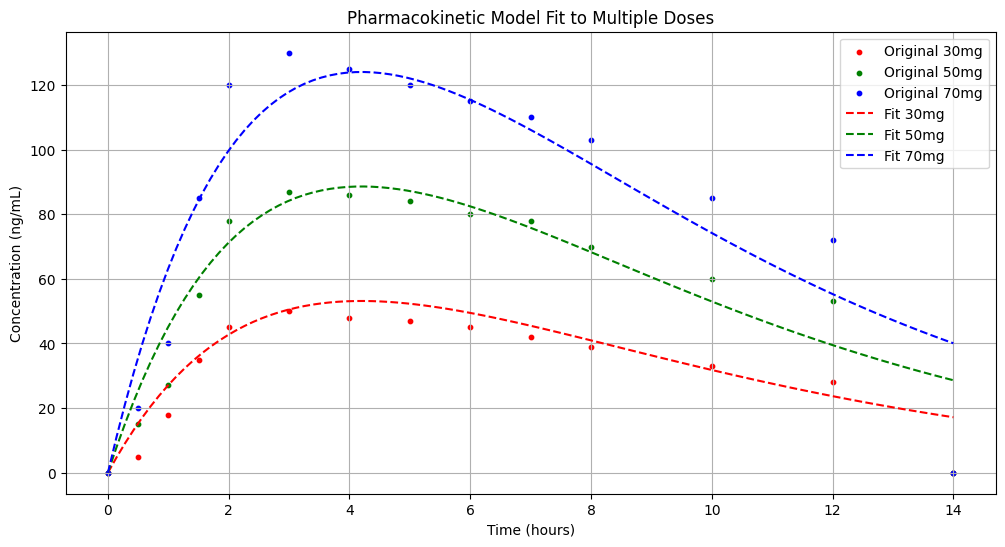

In [7]:
# Plot the original data and the fits
plt.figure(figsize=(12, 6))
# Original data
plt.scatter(df["time"], df["30mg"], label="Original 30mg", color="red", s=10)
plt.scatter(df["time"], df["50mg"], label="Original 50mg", color="green", s=10)
plt.scatter(df["time"], df["70mg"], label="Original 70mg", color="blue", s=10)
# Fitted curves
plt.plot(
    time_continuous, predictions_30mg, label="Fit 30mg", color="red", linestyle="dashed"
)
plt.plot(
    time_continuous,
    predictions_50mg,
    label="Fit 50mg",
    color="green",
    linestyle="dashed",
)
plt.plot(
    time_continuous,
    predictions_70mg,
    label="Fit 70mg",
    color="blue",
    linestyle="dashed",
)

plt.xlabel("Time (hours)")
plt.ylabel("Concentration (ng/mL)")
plt.title("Pharmacokinetic Model Fit to Multiple Doses")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
markdown_template = """
# Results
This worked great. To give more practical feedback $K_e$ has been manually slightly adjusted. So that:
$$
\\left( \\frac{{C_{{\\text{{max}}}} \\cdot K_a}}{{K_a - K_e}} \\right) \\left( e^{{-K_e \\cdot t}} - e^{{-K_a \\cdot t}} \\right)
$$

With the fitted values:
- $C_{{\\text{{max}}}} =$ {params[0]}
- $K_a =$ {params[1]}
- $K_e =$ {params[2]}
"""

# Replace placeholders with the actual values
markdown_text = markdown_template.format(params=params)
# Cmax=params[0], Ka=params[1], Ke=params[2])

# Display the formatted markdown
display(Markdown(markdown_text))


# Results
This worked great. To give more practical feedback $K_e$ has been manually slightly adjusted. So that:
$$
\left( \frac{C_{\text{max}} \cdot K_a}{K_a - K_e} \right) \left( e^{-K_e \cdot t} - e^{-K_a \cdot t} \right)
$$

With the fitted values:
- $C_{\text{max}} =$ 4.816931830999022
- $K_a =$ 0.23815199140828144
- $K_e =$ 0.7144975482181155


In [12]:
def total_and_individual_concentration_over_time(dose_times, params):
    # Generate a time array for the day from 5 AM to midnight, assuming minute intervals
    time_array = np.linspace(5, 24, (24 - 5) * 60)  # Minute intervals
    total_concentration = np.zeros_like(time_array)
    individual_concentrations = []

    for dose_info in dose_times:
        # Extract the dose time and the amount
        dose_time, dose_amount = dose_info
        # Calculate time passed since the dose was taken
        time_since_dose = time_array - dose_time
        # Calculate individual concentration
        individual_concentration = np.where(
            time_since_dose > 0,
            predict_concentration(time_since_dose, *params, dose_amount),
            0,
        )
        # Update total concentration
        total_concentration += individual_concentration
        individual_concentrations.append(individual_concentration)

    return time_array, total_concentration, individual_concentrations


def calculate_concentrations_and_plot(dose_times):
    # Calculate total and individual concentrations
    time_array, total_concentration, individual_concentrations = (
        total_and_individual_concentration_over_time(dose_times, params_quicker_decay)
    )

    # Plotting the total and individual concentrations over the day
    plt.figure(figsize=(12, 4))

    # Individual concentrations
    for i, concentration in enumerate(individual_concentrations, start=1):
        plt.plot(
            time_array, concentration, label=f"{dose_times[i-1][1]}mg", linestyle="--"
        )

    # Total concentration
    plt.plot(
        time_array,
        total_concentration,
        label="Total Concentration",
        color="black",
        linewidth=2,
    )
    plt.hlines(20, 5, 22, "r")

    plt.xlabel("Hour of the Day")
    plt.ylabel("Concentration (ng/mL)")
    plt.title("Total and Individual Medication Concentrations Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(5, 24)
    plt.xticks(np.arange(5, 25, 1))  # Hourly ticks
    plt.show()

In [13]:
params

(4.816931830999022, 0.23815199140828144, 0.7144975482181155)